In [0]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class Hidden_Layer():
    def __init__(self, nr_inputs, nr_outputs):
        self.number_inputs = nr_inputs
        self.number_outputs = nr_outputs
        self.W = np.random.randn(nr_inputs, nr_outputs) / np.sqrt(nr_inputs)
      
    def forward(self, x):
        self.x = list(x)
        # Add 1.0 for bias instead of putting it in the matrix
        
        self.x.append(1.0)
        self.x = np.array(self.x)

        return np.dot(self.x, self.W)
    
    def backward(self, derivative, alpha):
        
        for i in range(self.number_outputs):
            # Delta rule for updating weights
            # Alpha = 0.01
            self.W[:, i] -= alpha * (derivative[i] * self.x) 
            
        x_gradient = np.zeros([self.number_inputs - 1])
        
        for i in range(self.number_outputs):
            x_gradient += self.W[:-1, i] * derivative[i]

        return x_gradient

In [0]:
class M_Hidden_Layer(Hidden_Layer):
    def __init__(self, nr_inputs, nr_outputs, momentum):
        super().__init__(nr_inputs, nr_outputs)        
        self.velocity = np.zeros(shape = (nr_inputs, nr_outputs))
        self.momentum = momentum
        
    def backward(self, derivative, alpha):
        
        for i in range(self.number_outputs):
            self.velocity[:,i] = self.velocity[:,i] * self.momentum  - alpha * derivative[i] * self.x
            self.W[:,i] += self.velocity[:,i]
            
        x_gradient = np.zeros([self.number_inputs - 1])
        
        for i in range(self.number_outputs):
            x_gradient += self.W[:-1, i] * derivative[i]
            
        return x_gradient

In [0]:
# Nesterov Momentum Optimization Rule
class N_Hidden_Layer(M_Hidden_Layer):
    def __init__(self, nr_inputs, nr_outputs, momentum):
        super().__init__(nr_inputs, nr_outputs, momentum)

    def backward(self, derivative, alpha):
        
        for i in range(self.number_outputs):
            update = self.velocity[:, i] * self.momentum
            self.velocity[:,i] =  update  - alpha *(derivative[i] * self.x +  update)
            self.W[:,i] += self.velocity[:,i]
            
        x_gradient = np.zeros([self.number_inputs - 1])
        
        for i in range(self.number_outputs):
            x_gradient += self.W[:-1, i] * derivative[i]
            
        return x_gradient

In [0]:
class RMS_Hidden_Layer(M_Hidden_Layer):
    def __init__(self, nr_inputs, nr_outputs, momentum):
        super().__init__(nr_inputs, nr_outputs, momentum)

    def backward(self, derivative, alpha, epsi = 1e-8):
        
        for i in range(self.number_outputs):
            
            dw = derivative[i] * self.x
            self.velocity[:,i] =  self.velocity[:, i] * self.momentum  + (1 - self.momentum)*(dw**2)
            self.W[:,i] -= alpha * ( (dw) / (np.sqrt(self.velocity[:, i]) + epsi))
            
        x_gradient = np.zeros([self.number_inputs - 1])
        
        for i in range(self.number_outputs):
            x_gradient += self.W[:-1, i] * derivative[i]
            
        return x_gradient 
      

In [0]:
class Adam_Hidden_layer(Hidden_Layer):
    def __init__(self ,nr_inputs, nr_outputs, beta1, beta2):
        super().__init__(nr_inputs, nr_outputs)
        self.beta1 = beta1
        self.beta2 = beta2
        self.iteration = 1
        self.velocity = np.zeros(shape = (nr_inputs, nr_outputs))
        self.RMS = np.zeros(shape = (nr_inputs, nr_outputs))
        
    def backward(self, derivative, alpha, epsi = 1e-8):
    
        for i in range(self.number_outputs):
            dw = derivative[i] * self.x
            
            self.velocity[:,i] = self.beta1 * self.velocity[:, i] + (1 - self.beta1) * dw
            self.RMS[:, i] = self.beta2 * self.RMS[:, i] + (1 - self.beta2) * (dw ** 2)
            
            vCorrected = self.velocity[:, i] / (1 - (self.beta1 ** self.iteration))
            sCorrected = self.RMS[:, i] / (1 - (self.beta2 ** self.iteration))
            
            self.W[:,i] -= alpha * ( vCorrected / (np.sqrt(sCorrected) + epsi))
        
        self.iteration += 1
        x_gradient = np.zeros([self.number_inputs - 1])
        
        for i in range(self.number_outputs):
            x_gradient += self.W[:-1, i] * derivative[i]
            
        return x_gradient

In [0]:
class Sigmoid():
    def forward(self, x):
        self.output = np.array([1 / (1 + np.exp(-elem)) for elem in x])
        return self.output
    
    def backward(self, derivative):
        return (1 - self.output)*self.output*derivative

In [0]:
class GD_NN():
    def __init__(self, input_size, output_size, alpha):
        
        self.hidden_layer_size = 16
        self.hl_1 = Hidden_Layer(input_size + 1, self.hidden_layer_size)
        self.hl_2 = Hidden_Layer(self.hidden_layer_size + 1, output_size)
        self.sig = Sigmoid()
        self.alpha = alpha
        self.train_losses = []
        self.test_losses = []

    def train(self):
        cost = 0
        for i in range(n_train_images):
            
            x = x_train[i]
    
            output1 = self.hl_1.forward(x)
            output2 = self.hl_2.forward(output1)
            sig_val = self.sig.forward(output2)
        
            cost += (sig_val - y_train[i])
               
        cost /= n_train_images
        self.train_losses.append(sum(0.5*(cost)**2))
        
        sig_g = self.sig.backward(cost)
        fc2_g = self.hl_2.backward(sig_g, self.alpha)
        self.hl_1.backward(fc2_g, self.alpha)
           
    def test(self):
        score = 0.0
        loss = 0.0
        for i in range(n_test_images):
        
            x = x_test[i]
    
            fc1_val = self.hl_1.forward(x)
            fc2_val = self.hl_2.forward(fc1_val)
            sig_val = self.sig.forward(fc2_val)
        
            # GET THE INDEX OF MAXIMUM ACTIVATION
            predicted_label = np.argmax(sig_val)

            correct_label = np.argmax(y_test[i])
        
            # MSE LOSS 
            loss += sum(0.5*(sig_val - y_test[i])**2)
        
            # NUMBER OF CORRECTLY PREDICTED LABELS
            score += correct_label == predicted_label
        
        
        self.test_losses.append(loss / n_test_images)
        #print('Loss: {:0.2f}'.format(loss / n_test_images))
        print('Accuracy: {:2.2f}'.format(score / n_test_images * 100))
 
    def learn(self, epochs):
        for i in range(epochs):
            print('Training epoch: {}'.format(i))
            self.train()
            self.test()

In [0]:
class SGD_NN(GD_NN):
    def __init__(self, input_size, output_size, alpha):
        super().__init__(input_size, output_size, alpha)
        self.train_losses = []
                
    def shuffle_data(self, x, y):
        p = np.random.permutation(x.shape[0])
        return x[p], y[p]
            
    def train(self):
        
        cost = 0
        
        train_data, train_labels = self.shuffle_data(x_train, y_train)
        
        for i in range(n_train_images):
            x = train_data[i]
                
            output1 = self.hl_1.forward(x)
            output2 = self.hl_2.forward(output1)
            sig_val = self.sig.forward(output2)
        
            t =  sig_val - train_labels[i]
            cost += sum(0.5*(sig_val - train_labels[i])**2)
            
            
            sig_g = self.sig.backward(t)
            fc2_g = self.hl_2.backward(sig_g, self.alpha)
            self.hl_1.backward(fc2_g, self.alpha)

        cost /= n_train_images
        self.train_losses.append(cost)
        #print('Cost function: {}'.format(np.sum(cost ** 2)))
        
    def plot_losses(self):
        plt.plot(self.train_losses)
        plt.plot(self.test_losses)
        #plt.show()

In [0]:
class M_SGD_NN(SGD_NN):
    def __init__(self, input_size, output_size, alpha, momentum):
        
        super().__init__(input_size, output_size, alpha)
        
        self.hl_1 = M_Hidden_Layer(input_size + 1, self.hidden_layer_size,
                                   momentum)
        self.hl_2 = M_Hidden_Layer(self.hidden_layer_size + 1, output_size,
                                   momentum)
  

In [0]:
class NM_SGD_NN(M_SGD_NN):
    def __init__(self, input_size, output_size, alpha, momentum):
      
      super().__init__(input_size, output_size, alpha, momentum)
      
      self.hl_1 = N_Hidden_Layer(input_size + 1, self.hidden_layer_size,
                                   momentum)
      self.hl_2 = N_Hidden_Layer(self.hidden_layer_size + 1, output_size,
                                   momentum)

In [0]:
class RMS_NN(GD_NN):
    def __init__(self, input_size, output_size, alpha, momentum):
        
        super().__init__(input_size, output_size, alpha)
        
        self.hl_1 = RMS_Hidden_Layer(input_size + 1, self.hidden_layer_size,
                                   momentum)
        self.hl_2 = RMS_Hidden_Layer(self.hidden_layer_size + 1, output_size,
                                   momentum)
        
        self.train_losses = []
        
        
    def train(self):
        cost = 0

        for i in range(n_train_images):
            #if i % 20000 == 0:
             #   print('Percent done: {:2.0f}%'.format(i/n_train_images * 100))
            
            x = x_train[i]
    
            output1 = self.hl_1.forward(x)
            output2 = self.hl_2.forward(output1)
            sig_val = self.sig.forward(output2)
        
            loss = sig_val - y_train[i]
            cost += sum(0.5*(sig_val - y_train[i])**2)
            
            sig_g = self.sig.backward(loss)
            fc2_g = self.hl_2.backward(sig_g, self.alpha)
            self.hl_1.backward(fc2_g, self.alpha)
            
            
        cost /= n_train_images
        #print('Cost function: {}'.format())
        self.train_losses.append(cost)
       

In [0]:
class ADAM_NN(SGD_NN):
    def __init__(self, input_size, output_size, alpha, beta1, beta2):
        
        super().__init__(input_size, output_size, alpha)
        
        self.hl_1 = Adam_Hidden_layer(input_size + 1, self.hidden_layer_size,
                                   beta1, beta2)
        self.hl_2 = Adam_Hidden_layer(self.hidden_layer_size + 1, output_size,
                                   beta1, beta2)

In [0]:
def convert_to_one_hot(y):    
    one_hot = np.zeros((y.size, y.max()+1))
    one_hot[np.arange(y.size), y] = 1
    
    return one_hot

In [15]:
# Load data
mnist = tf.keras.datasets.mnist

# 0 - 255 for train, 0 - 9 for labels
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

n_train_images = len(x_train)
n_test_images = len(x_test)

x_train = x_train.reshape(n_train_images, -1)
x_test = x_test.reshape(n_test_images, -1)

# Convert to one hot
y_train = convert_to_one_hot(y_train)
y_test = convert_to_one_hot(y_test)


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
models = [GD_NN(x_train[0].shape[0], 10, 0.001), 
          SGD_NN(x_train[0].shape[0], 10, 0.001), 
          M_SGD_NN(x_train[0].shape[0], 10, 0.001, 0.9),
          NM_SGD_NN(x_train[0].shape[0], 10, 0.001, 0.9),
          RMS_NN(x_train[0].shape[0], 10, 0.001, 0.9),
          ADAM_NN(x_train[0].shape[0], 10, 0.001, 0.9,0.999)
          ]

model_names = ['GD',
               'SGD',
               'SGD with Momentum',
               'SGD with Nesterov Momentum',
               'RMSProp',
               'ADAM']

In [17]:
GD_nn = models[0]
GD_nn.learn(20)

Training epoch: 0
Accuracy: 16.29
Training epoch: 1
Accuracy: 16.39
Training epoch: 2
Accuracy: 16.41
Training epoch: 3
Accuracy: 16.45
Training epoch: 4
Accuracy: 16.50
Training epoch: 5
Accuracy: 16.54
Training epoch: 6
Accuracy: 16.58
Training epoch: 7
Accuracy: 16.65
Training epoch: 8
Accuracy: 16.66
Training epoch: 9
Accuracy: 16.75
Training epoch: 10
Accuracy: 16.82
Training epoch: 11
Accuracy: 16.90
Training epoch: 12
Accuracy: 16.92
Training epoch: 13
Accuracy: 16.95
Training epoch: 14
Accuracy: 17.07
Training epoch: 15
Accuracy: 17.17
Training epoch: 16
Accuracy: 17.26
Training epoch: 17
Accuracy: 17.30
Training epoch: 18
Accuracy: 17.34
Training epoch: 19
Accuracy: 17.38


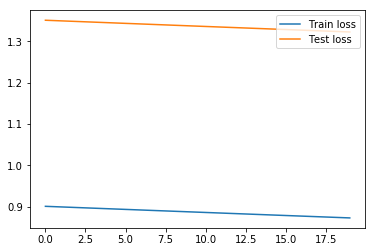

In [18]:
plt.plot(GD_nn.train_losses, label = 'Train loss')
plt.plot(GD_nn.test_losses, label = 'Test loss')
plt.legend(loc='upper right')
plt.show()

In [19]:
SGD_nn = models[1]
SGD_nn.learn(20)

Training epoch: 0
Accuracy: 86.89
Training epoch: 1
Accuracy: 89.20
Training epoch: 2
Accuracy: 90.19
Training epoch: 3
Accuracy: 90.69
Training epoch: 4
Accuracy: 90.98
Training epoch: 5
Accuracy: 91.13
Training epoch: 6
Accuracy: 91.14
Training epoch: 7
Accuracy: 91.46
Training epoch: 8
Accuracy: 91.44
Training epoch: 9
Accuracy: 91.53
Training epoch: 10
Accuracy: 91.60
Training epoch: 11
Accuracy: 91.66
Training epoch: 12
Accuracy: 91.64
Training epoch: 13
Accuracy: 91.70
Training epoch: 14
Accuracy: 91.66
Training epoch: 15
Accuracy: 91.75
Training epoch: 16
Accuracy: 91.71
Training epoch: 17
Accuracy: 91.71
Training epoch: 18
Accuracy: 91.78
Training epoch: 19
Accuracy: 91.75


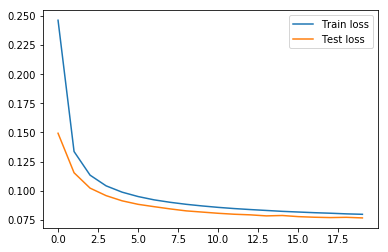

In [20]:
plt.plot(SGD_nn.train_losses, label = 'Train loss')
plt.plot(SGD_nn.test_losses, label = 'Test loss')
plt.legend(loc='upper right')
plt.show()

In [21]:
M_SGD_nn = models[2]
M_SGD_nn.learn(20)

Training epoch: 0
Accuracy: 90.97
Training epoch: 1
Accuracy: 91.35
Training epoch: 2
Accuracy: 91.21
Training epoch: 3
Accuracy: 91.73
Training epoch: 4
Accuracy: 91.72
Training epoch: 5
Accuracy: 91.92
Training epoch: 6
Accuracy: 91.98
Training epoch: 7
Accuracy: 92.11
Training epoch: 8
Accuracy: 91.77
Training epoch: 9
Accuracy: 91.81
Training epoch: 10
Accuracy: 92.11
Training epoch: 11
Accuracy: 91.97
Training epoch: 12
Accuracy: 91.62
Training epoch: 13
Accuracy: 92.07
Training epoch: 14
Accuracy: 92.08
Training epoch: 15
Accuracy: 92.14
Training epoch: 16
Accuracy: 92.22
Training epoch: 17
Accuracy: 92.15
Training epoch: 18
Accuracy: 92.41
Training epoch: 19
Accuracy: 92.04


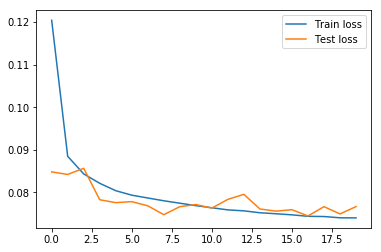

In [22]:
plt.plot(M_SGD_nn.train_losses, label = 'Train loss')
plt.plot(M_SGD_nn.test_losses, label = 'Test loss')
plt.legend(loc='upper right')
plt.show()

In [24]:
NM_SGD_nn = models[3]
NM_SGD_nn.learn(20)


Training epoch: 0
Accuracy: 90.95
Training epoch: 1
Accuracy: 91.41
Training epoch: 2
Accuracy: 91.34
Training epoch: 3
Accuracy: 91.73
Training epoch: 4
Accuracy: 91.72
Training epoch: 5
Accuracy: 91.82
Training epoch: 6
Accuracy: 91.68
Training epoch: 7
Accuracy: 91.74
Training epoch: 8
Accuracy: 92.06
Training epoch: 9
Accuracy: 92.13
Training epoch: 10
Accuracy: 91.81
Training epoch: 11
Accuracy: 91.94
Training epoch: 12
Accuracy: 92.05
Training epoch: 13
Accuracy: 91.93
Training epoch: 14
Accuracy: 92.01
Training epoch: 15
Accuracy: 92.02
Training epoch: 16
Accuracy: 91.88
Training epoch: 17
Accuracy: 92.39
Training epoch: 18
Accuracy: 92.43
Training epoch: 19
Accuracy: 92.47


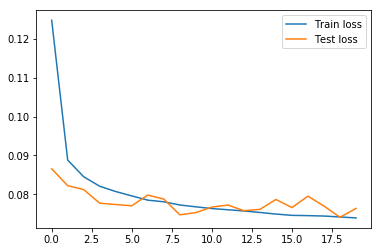

In [25]:
plt.plot(NM_SGD_nn.train_losses, label = 'Train loss')
plt.plot(NM_SGD_nn.test_losses, label = 'Test loss')
plt.legend(loc='upper right')
plt.show()

In [26]:
RMS_nn = models[4]
RMS_nn.learn(20)


Training epoch: 0
Accuracy: 89.29
Training epoch: 1
Accuracy: 89.92
Training epoch: 2
Accuracy: 90.05
Training epoch: 3
Accuracy: 90.14
Training epoch: 4
Accuracy: 90.16
Training epoch: 5
Accuracy: 90.56
Training epoch: 6
Accuracy: 90.49
Training epoch: 7
Accuracy: 90.63
Training epoch: 8
Accuracy: 90.53
Training epoch: 9
Accuracy: 90.68
Training epoch: 10
Accuracy: 90.53
Training epoch: 11
Accuracy: 90.50
Training epoch: 12
Accuracy: 91.06
Training epoch: 13
Accuracy: 90.78
Training epoch: 14
Accuracy: 90.82
Training epoch: 15
Accuracy: 90.91
Training epoch: 16
Accuracy: 90.96
Training epoch: 17
Accuracy: 91.10
Training epoch: 18
Accuracy: 91.07
Training epoch: 19
Accuracy: 91.22


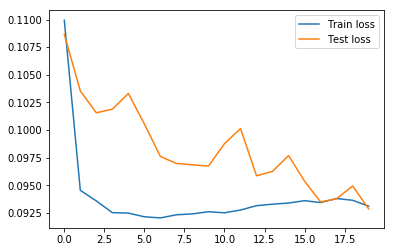

In [27]:
plt.plot(RMS_nn.train_losses, label = 'Train loss')
plt.plot(RMS_nn.test_losses, label = 'Test loss')
plt.legend(loc='upper right')
plt.show()

In [28]:
ADAM_nn = models[5]
ADAM_nn.learn(20)

Training epoch: 0
Accuracy: 91.58
Training epoch: 1
Accuracy: 91.60
Training epoch: 2
Accuracy: 91.68
Training epoch: 3
Accuracy: 91.62
Training epoch: 4
Accuracy: 91.56
Training epoch: 5
Accuracy: 91.83
Training epoch: 6
Accuracy: 91.51
Training epoch: 7
Accuracy: 91.33
Training epoch: 8
Accuracy: 91.66
Training epoch: 9
Accuracy: 91.87
Training epoch: 10
Accuracy: 90.86
Training epoch: 11
Accuracy: 91.98
Training epoch: 12
Accuracy: 91.28
Training epoch: 13
Accuracy: 91.89
Training epoch: 14
Accuracy: 91.67
Training epoch: 15
Accuracy: 91.25
Training epoch: 16
Accuracy: 91.22
Training epoch: 17
Accuracy: 90.43
Training epoch: 18
Accuracy: 91.81
Training epoch: 19
Accuracy: 91.84


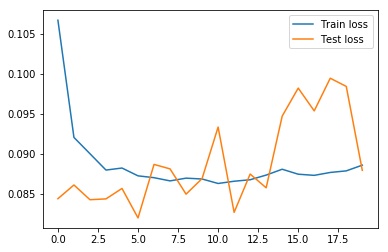

In [29]:
plt.plot(ADAM_nn.train_losses, label = 'Train loss')
plt.plot(ADAM_nn.test_losses, label = 'Test loss')
plt.legend(loc='upper right')
plt.show()

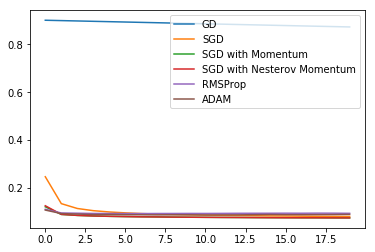

In [32]:
for i in range(1, len(models)):
  plt.plot(models[i].train_losses, label = model_names[i])

plt.legend(loc='upper right')
plt.show()